# Regression Model Comparison


In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math

%matplotlib inline
sns.set_style('white')

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Preparing Data

## Read in data

In [118]:
# Read in data
df = pd.read_csv('mpg.csv')

In [117]:
# Preview data
df.head()

,mpg,cylinders,displacement,horsepower,weight
0,18.000,8,307.000,130,3504
1,15.000,8,350.000,165,3693
2,18.000,8,318.000,150,3436
3,16.000,8,304.000,150,3433
4,17.000,8,302.000,140,3449


## Clean Data

In [119]:
# Replace '?' values with NaN values
df = df.replace('?', np.NaN)

In [120]:
# Evaluate where the NaN values exist
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
dtype: int64

In [121]:
# There aren't many NaN values, so we'll just drop the rows with NaN values
# in lieu of imputing anything. 

df = df.dropna()

In [122]:
# Convert all objects to numeric 

df = df.apply(pd.to_numeric,errors='coerce')

## Model

### OLS Regression

In [72]:
#Instantiate and fit model
regr = linear_model.LinearRegression()
Y = df['mpg']
X = df[['cylinders','displacement','horsepower','weight']]
regr.fit(X, Y)

#Inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ -3.93285431e-01   1.38893129e-04  -4.28124811e-02  -5.27717310e-03]

Intercept: 
 45.7567705221

R-squared:
0.707652073833


#### Cross Validate

In [73]:
#Initialize standardizer, pipeline and KFold. Also standardize data during cross validation.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

standardizer = StandardScaler()
pipeline = make_pipeline(standardizer, regr)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [74]:
#Append results of crossvalidation to cv_results
cv_results = cross_val_score(pipeline, 
                             X, 
                             Y, 
                             cv=kf, 
                             n_jobs=-1)

cv_results.mean()

0.70168770155302862

#### Evaluate

##### Normality Assessment

The residuals appear to be mostly normal, with a slight skew

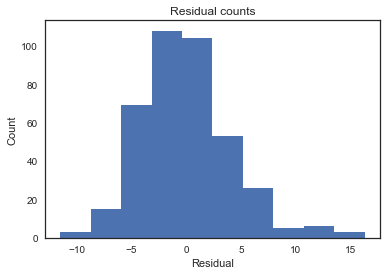

In [110]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['mpg'].astype(float)

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

##### Scedasticity Assessment

The model appears to perform well with low to moderate predictions. 

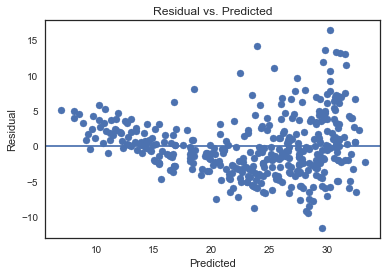

In [111]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### KNN Regression

In [103]:
## Run the same model, this time with weights.
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance')
X = np.array(df.drop('mpg',axis=1))
Y = np.array(df['mpg']).reshape(-1,1)
knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

#### Cross validate

In [104]:
#Initialize standardizer, pipeline and KFold. Also standardize data during cross validation.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

standardizer = StandardScaler()
pipeline = make_pipeline(standardizer, knn)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [105]:
#Append results of crossvalidation to cv_results
cv_results = cross_val_score(pipeline, 
                             X, 
                             Y, 
                             cv=kf, 
                             n_jobs=-1)

cv_results.mean()

0.77016047768923857

#### Evaluate

##### Normality Assessment

Much to my surprise, the model appears to appears to have far less variance compared to OLS regresison. 

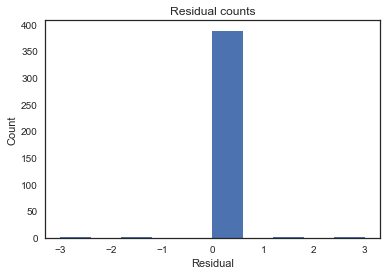

In [114]:
# Extract predicted values.
predicted = knn.predict(X).ravel()
actual = df['mpg'].astype(float)

# Calculate error
residual = actual - predicted

# Plot residuals
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

##### Scedasticity Assessment

The distribution of residuals also appears to be homoscedastic for the most part. 

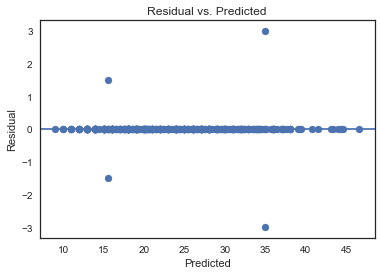

In [115]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Conclusion

Compared to the OLS regression, the variance in residuals is considerably less in the KNN regression model. Moreover, those instances that deviate from 0 are few and far between. Both of these observations suggest that the predictions from the KNN model are more reliable.  

In this case, perhaps one of the limitations of OLS regression is that the model is trying to look at the data set as a whole and estimate the inputs in a function to minimize error, which would work well for data where the features and target variable behave in a relatively linear fashion. 

In the case of this data set, the relationship between the features and the target variable, mpg, do not behave in a perfectly linear manner. Therefore, perhaps KNN regression is more appropriate as it is, by its very nature, more sensitive to nuance in the data. 

On the other hand, if you're working with a features + target pair that behaves more or less linearly with a small subset of outliers -- a linear model might actually perform better whereas KNN regression might accidentally pick up on noise from the outliers. 